# Normalizing Flow
- Variational Inference

In [1]:

#@title install packages
!pip install watermark
!pip install japanize-matplotlib
# !pip install torch==1.10.0
# !pip install pyro-ppl==1.7.0
!pip install pyro-ppl
!pip install japanize-matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=3266e96833c7746f607cd568e3b4d217dc541ad61818ea8da1a0d388c09c3edf
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s

In [2]:

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import japanize_matplotlib

import torch
import pyro
from pyro import distributions
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions.transforms as T
from pyro.optim import Adam

<ipython-input-3-2a602622e74c>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmoid = torch.sigmoid(torch.matmul(torch.tensor(x_with_bias).double(), torch.tensor(w).double()))


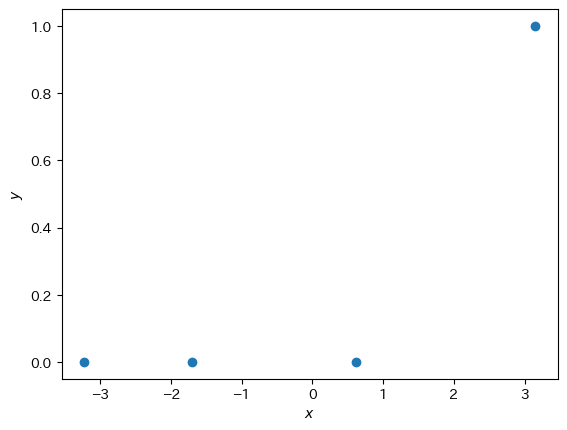

In [3]:

torch.manual_seed(20)

# データ数
N=4
# 説明変数のサンプル
x_data = torch.distributions.uniform.Uniform(-5, 5).sample([N, 1])

# トイデータの生成関数
def data_generation_process(x):
    bias = torch.ones_like(x)
    x_with_bias = torch.cat([x, bias], axis=1)
    w =  pyro.sample('w', distributions.Normal(torch.tensor([0.0, 0.0]), torch.tensor([5.0, 5.0])).to_event(1))
    sigmoid = torch.sigmoid(torch.matmul(torch.tensor(x_with_bias).double(), torch.tensor(w).double()))
    dist = distributions.Bernoulli(sigmoid)
    return dist

# 目的変数のサンプル
y_data = data_generation_process(x_data).sample()

plt.scatter(x=x_data, y=y_data);
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-4-7d2cf196169d>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sig = torch.sigmoid(torch.matmul(torch.tensor(x_with_bias).double(), torch.tensor(w).double())).T


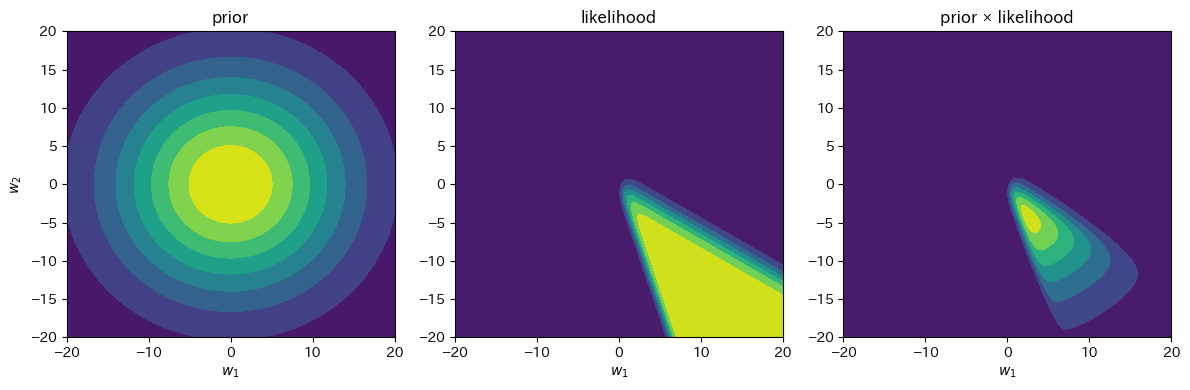

In [4]:
# 対数のlogprobを計算する関数
def log_p_y_z(w, x, y):
    bias = torch.ones_like(x)
    x_with_bias = torch.cat([x, bias], axis=1)
    sig = torch.sigmoid(torch.matmul(torch.tensor(x_with_bias).double(), torch.tensor(w).double())).T
    bern = distributions.Bernoulli(probs=sig).to_event(0)
    return torch.sum(bern.log_prob(y), axis=1)

# 事前分布のlogprobを計算する関数
def log_prob_w(w):
    norm = distributions.Normal(loc=torch.tensor([0.0,0.0]), scale=torch.tensor([10.0,10.0])).to_event(1)
    return norm.log_prob(w.T)

# 二次元のパラメータの格子点
plot_num=300
max_grid = 20
w1 = torch.linspace(-max_grid, max_grid, plot_num)
w2 = torch.linspace(-max_grid, max_grid, plot_num)
W1_grid, W2_grid = torch.meshgrid(w1, w2)
W12_grid = torch.tensor([[w1,w2] for w1, w2 in zip(W1_grid.ravel(), W2_grid.ravel())]).T

# 事前分布のlogprob
log_prior = log_prob_w(W12_grid).reshape(plot_num, plot_num)
# 尤度のlogprob
log_likelihoods = log_p_y_z(W12_grid, x_data, y_data).reshape(plot_num, plot_num)

fig, ax = plt.subplots(figsize=(12,4), ncols=3)
ax[0].contourf(W1_grid, W2_grid, torch.exp(log_prior))
ax[0].set_title('prior')
ax[1].contourf(W1_grid, W2_grid, torch.exp(log_likelihoods))
ax[1].set_title('likelihood')
ax[2].contourf(W1_grid, W2_grid, torch.exp(log_prior+log_likelihoods))
ax[2].set_title('prior × likelihood')
for i in range(3):
  ax[i].set_xlabel(r'$w_1$')
ax[0].set_ylabel(r'$w_2$')
plt.tight_layout();


## Model Definition

In [11]:
#initialize parameters
pyro.clear_param_store()
#function to be enrolled
def register_pyro_module(flows,N_flows):
  for i in range(N_flows):
    nf_module = pyro.module(f"flow_{i}",flows[i])

#dim
dim=2
#gaussian distribution before transformation
base_dist = distributions.Normal(torch.zeros(dim),torch.ones(dim))
#
#num of transformation
N_flows = 10
#planar flow transformation
flows = []
for _ in range(N_flows):
  flow = T.Planar(input_dim=dim)
  flows.append(flow)
#transformed distribution
guide_NF_dist = distributions.TransformedDistribution(base_dist,flows)

#approximate function
def guide_NF(x,y):
  register_pyro_module(flows,N_flows)
  pyro.sample("w",guide_NF_dist)

#generative process of logistic regression
def model(x,y):
  bias = torch.ones_like(x)
  x_with_bias = torch.cat([x,bias],axis=1)
  w=pyro.sample("w",distributions.Normal(torch.tensor([0,0]),torch.tensor([10,10])).to_event(1))

  with pyro.plate("data",x.shape[0]):
    sigmoid = torch.sigmoid(torch.matmul(x_with_bias,w))
    obs = pyro.sample("obs",distributions.Bernoulli(sigmoid),obs=y)

## Training

0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %


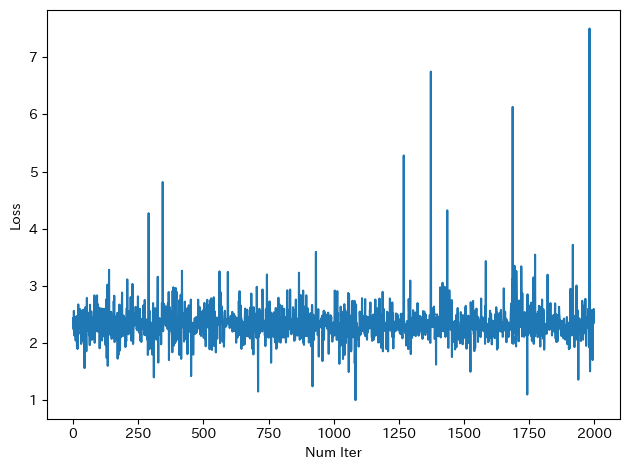

In [13]:
#optimizer
optimizer = Adam({"lr":0.005})
#setting for Stochastic Variational Inference
svi = SVI(model,guide_NF,optimizer,loss=Trace_ELBO(num_particles=3)) #The num_particles parameter is related to stochastic gradient estimation and controls the number of samples used to estimate the gradient of the ELBO.

torch.manual_seed(0)
#steps
n_steps=2000
loss_list=[]
for step in range(n_steps):
  if step%200==0:
    print(round(step/n_steps*100,1),"%")
  #loss and optimization
  loss=svi.step(x_data,y_data)
  loss_list.append(loss)

plt.plot(loss_list)
plt.xlabel("Num Iter")
plt.ylabel("Loss")
plt.tight_layout()

## baseline : mean field approximation

In [14]:
from pyro.infer.autoguide import AutoDiagonalNormal

#mean approximate
guide_RF = AutoDiagonalNormal(model)

#posterior distribution
svi = SVI(model,guide_RF,optimizer,loss=Trace_ELBO())

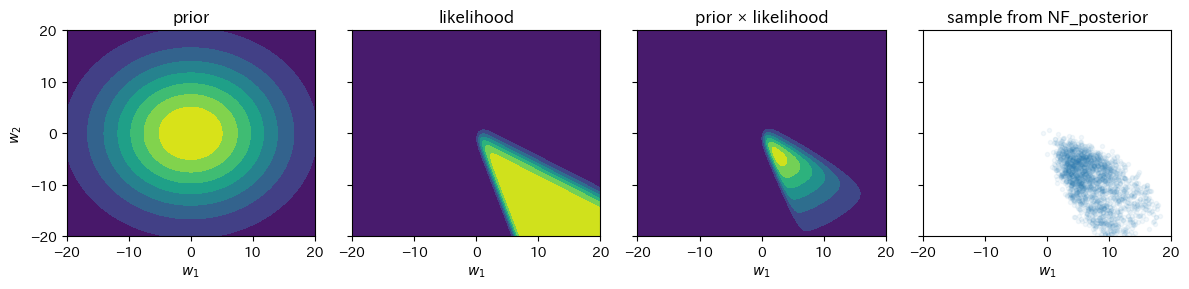

In [16]:

fig, ax = plt.subplots(figsize=(12,3), ncols=4, sharex=True, sharey=True)
ax[0].contourf(W1_grid, W2_grid, torch.exp(log_prior))
ax[0].set_title('prior')
ax[1].contourf(W1_grid, W2_grid, torch.exp(log_likelihoods))
ax[1].set_title('likelihood')
ax[2].contourf(W1_grid, W2_grid, torch.exp(log_prior+log_likelihoods))
ax[2].set_title('prior × likelihood')
nf_dist_opt_samples = guide_NF_dist.sample(torch.Size([2000])).numpy()
ax[3].scatter(x=nf_dist_opt_samples[:,0], y=nf_dist_opt_samples[:,1],marker='.', alpha=0.05)
ax[3].set_title('sample from NF_posterior')

for i in range(4):
  ax[i].set_xlabel(r'$w_1$')
ax[0].set_ylabel(r'$w_2$')
ax[0].set_xlim(-20, 20);ax[0].set_ylim(-20, 20)
plt.tight_layout();


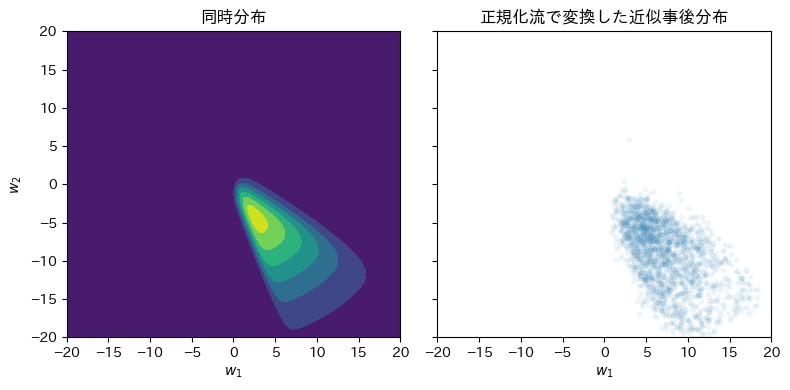

In [17]:

fig, ax = plt.subplots(figsize=(8,4), ncols=2, sharex=True, sharey=True)
# 同時分布の可視化
ax[0].contourf(W1_grid, W2_grid, torch.exp(log_prior+log_likelihoods))
ax[0].set_title('同時分布')

# 正規化流による変分推論をした近似事後分布からのサンプル
nf_samples = guide_NF_dist.sample(torch.Size([2000])).numpy()
ax[1].scatter(x=nf_samples[:,0], y=nf_samples[:,1],marker='.', alpha=0.05)
ax[1].set_title('正規化流で変換した近似事後分布')

for i in range(2):
  ax[i].set_xlabel(r'$w_1$')
ax[0].set_ylabel(r'$w_2$')
ax[0].set_xlim(-20, 20);ax[0].set_ylim(-20, 20)
plt.tight_layout();